In [1]:
import torch

import os

os.environ['TRANSFORMERS_CACHE'] = '../../pretrained_models/hugging_face'

from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
import re


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

d:\Alex_Karachun\DEV\neuroPushkin-nlp_project\.venv\Lib\site-packages\transformers\utils\hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


'cuda'

In [19]:
# model_name = "sberbank-ai/rugpt3medium_based_on_gpt2"
# tokenizer = GPT2Tokenizer.from_pretrained(model_name)
# model = GPT2LMHeadModel.from_pretrained(model_name).to(device)


model_name = "sberbank-ai/rugpt3medium_based_on_gpt2"
# model_path = f'sberbank-ai/rugpt3medium_based_on_gpt2_train/checkpoint-12000'

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

загружаю датасет

In [3]:
def load_dataset(file_paths, tokenizer, block_size=512, multip=20):
    tokenized_texts = []
    for path in file_paths:
        with open(path, 'r', encoding='utf-8') as f:
            texts = f.read()
            texts = texts.split('#' * 10)

            tokenized_texts.extend([tokenizer.encode(t.strip()) for t in texts if len(t) > 50])



    # изображу длины тектов в токенах для наглядности параметров block_size, multip
    lens = [len(t) for t in tokenized_texts]
    plt.figure(figsize=(16, 5))
    plt.scatter(np.arange(len(lens)), lens, c='purple', s=1)
    plt.title('длины текстов в токенах')
    plt.xlabel('тексты')
    plt.ylabel('длина в токенах')
    plt.show()
    
    # режу тексты на нахлестывающиеся отрезки
    overlapped_texts = []
    for text in tokenized_texts:
        if len(text) > block_size:
            step = max(1, (len(text) - block_size) // (multip - 1))
            for i in range(0, min(len(text) - block_size, block_size * (multip - 1) + 1), step):
                overlapped_texts.append(text[i: i + block_size])

    
    encodings = torch.tensor(overlapped_texts, dtype=torch.long)

    return encodings

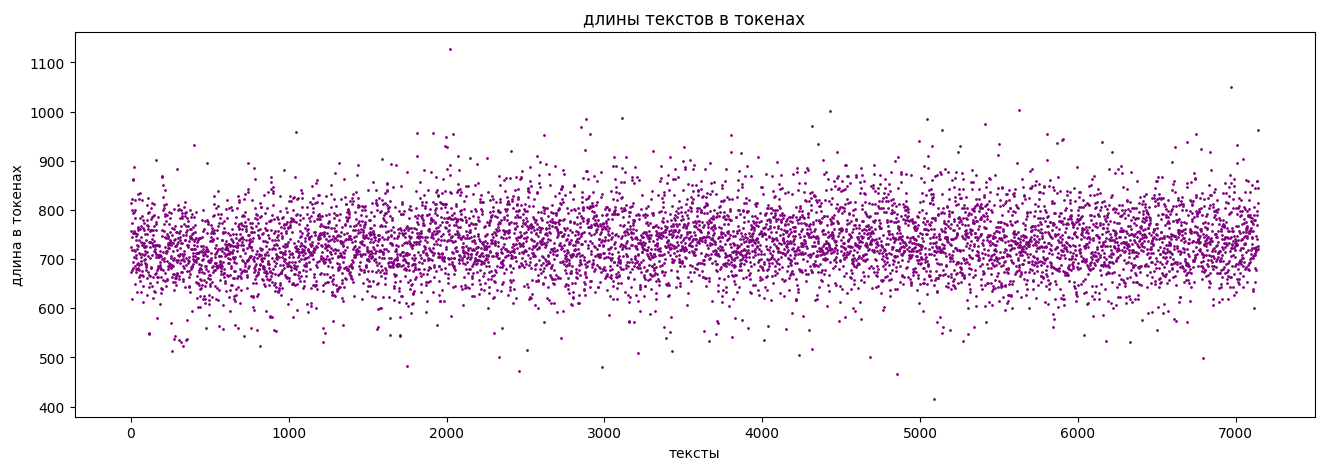

143835

In [4]:
splitted_texts = [
    '../dataset/clean/generated_curious_pushkin.txt',
    '../dataset/clean/generated_pushkin.txt',
]

fild_texts  = [
    '../dataset/clean/original_cleaned.txt',
]

block_size = 436  # 436+
multip = 7
train_dataset = load_dataset(splitted_texts, tokenizer, block_size=block_size)
len(train_dataset)



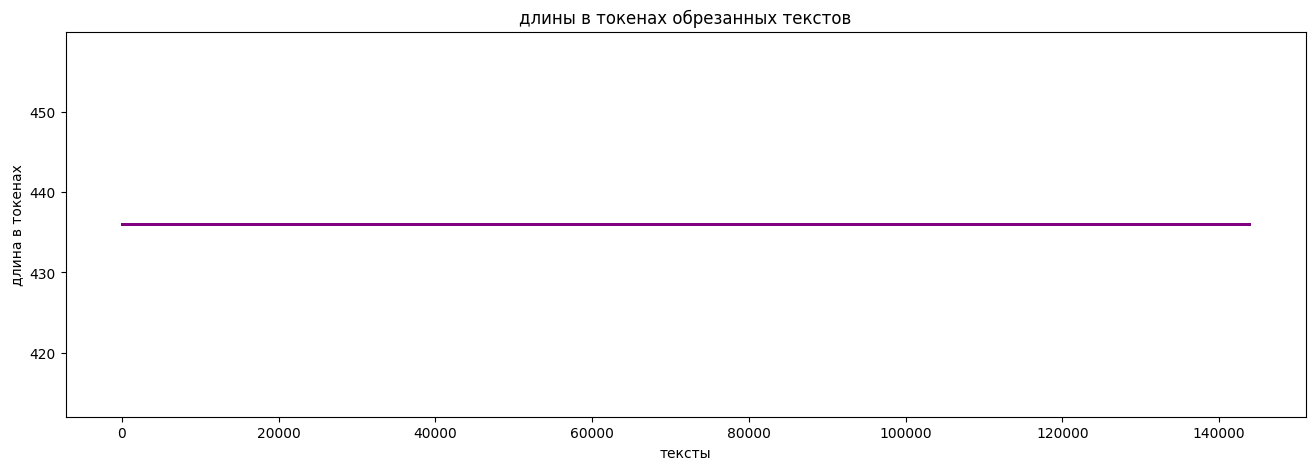

143835


In [5]:
lens = [len(t) for t in train_dataset]
plt.figure(figsize=(16, 5))
plt.title('длины в токенах обрезанных текстов')
plt.scatter(np.arange(len(lens)), lens, s=1, c='purple', alpha=0.1)
plt.xlabel('тексты')
plt.ylabel('длина в токенах')
plt.show()

print(len(train_dataset))

In [6]:
num_epochs = 1

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

training_args = TrainingArguments(
    output_dir=f'{model_name}_train',
    overwrite_output_dir=True,
    num_train_epochs=num_epochs,
    per_device_train_batch_size=2,
    save_steps=3_000,
    save_total_limit=100,
    fp16=True,
    logging_dir=f'{model_name}_train/logs', 
    logging_steps=500,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset[:],
)


d:\Alex_Karachun\DEV\neuroPushkin-nlp_project\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [7]:
trainer.train()

path = f'{model_name}_train/{model_name}_{num_epochs}_epochs'

trainer.save_model(path)
tokenizer.save_pretrained(path)


d:\Alex_Karachun\DEV\neuroPushkin-nlp_project\.venv\Lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss
500,3.000800
1000,2.880700
1500,2.811300
2000,2.772400
2500,2.755700
3000,2.707700
3500,2.700000
4000,2.654200
4500,2.616400
5000,2.612900


('sberbank-ai/rugpt3medium_based_on_gpt2_train/sberbank-ai/rugpt3medium_based_on_gpt2_1_epochs\\tokenizer_config.json',
 'sberbank-ai/rugpt3medium_based_on_gpt2_train/sberbank-ai/rugpt3medium_based_on_gpt2_1_epochs\\special_tokens_map.json',
 'sberbank-ai/rugpt3medium_based_on_gpt2_train/sberbank-ai/rugpt3medium_based_on_gpt2_1_epochs\\vocab.json',
 'sberbank-ai/rugpt3medium_based_on_gpt2_train/sberbank-ai/rugpt3medium_based_on_gpt2_1_epochs\\merges.txt',
 'sberbank-ai/rugpt3medium_based_on_gpt2_train/sberbank-ai/rugpt3medium_based_on_gpt2_1_epochs\\added_tokens.json')

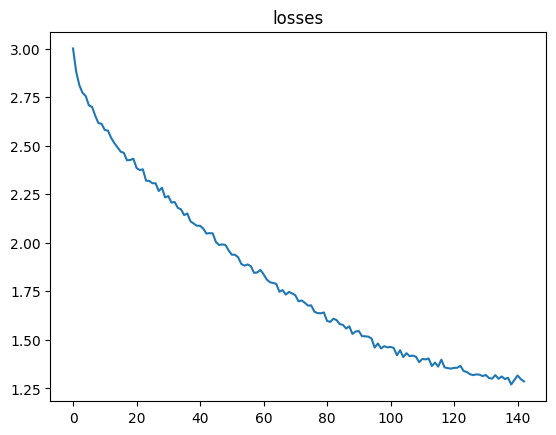

<Figure size 1600x500 with 0 Axes>

In [8]:
logs = trainer.state.log_history

losses = [i.get('loss') for i in logs]
plt.plot(losses)
plt.title('losses')
plt.figure(figsize=(16, 5))
plt.show()


In [6]:
model_name = "sberbank-ai/rugpt3medium_based_on_gpt2"

model_path =  f'sberbank-ai/rugpt3medium_based_on_gpt2_train/sberbank-ai/rugpt3medium_based_on_gpt2_1_epochs'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_path)



torch.cuda.is_available()

True

In [2]:
def generate_text(prompt, device, tokenizer):
    model.to(device)
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    output = model.generate(
        input_ids,
        min_length=64,
        max_length=512,
        num_beams=3,
        no_repeat_ngram_size=2,
        top_k=20, 
        top_p=0.8, 
        early_stopping=True,
        do_sample=True,
        temperature=0.7, 
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [8]:
prompt = "ночной волшебный лес то тут то там мелькал радужными неоновыми водопадами и таинственно мерцающими"
generated_texts = generate_text(prompt, device, tokenizer)
print(generated_texts)

d:\Alex_Karachun\DEV\neuroPushkin-nlp_project\.venv\Lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


ночной волшебный лес то тут то там мелькал радужными неоновыми водопадами и таинственно мерцающими огоньками, которые, казалось, звали его вглубь своих объятий. С каждым шагом он чувствовал, как мир вокруг него меняется, становясь все более загадочным и волшебным. Он встретил там существ, о которых лишь слышал в легендах: эльфов с нежными лицами, фей с крыльями из света и лунного блеска, мудрых сов, что делились тайными знаниями с заблудшими путниками. Каждый из них, наполняя его сердце восторгом и благоговением, рассказывал о далeких странах и незабываемых приключениях. Но вскоре Артемий начал понимать: чтобы увидеть эти чудеса, ему нужно было покинуть родные края. «Как же я могу оставить всe это?» — произнeс он, глядя на своих новых друзей. Волшебные существа грустно улыбались, а эльфы, печально покачивая головами, произнесли: «Судьба требует выбора. Ты должен выбрать: остаться в нашем мире, забыв о своих мечтах, или возвратиться к своей природе, к своим корням». Сердце Артемия запол

## Супер, оно работает
но я думаю, что модель переобучилась, тк под конец текста качество генерации значительно снижается.

С одной стороны, чем больше я учу rugpt3, тем хуже она говорит по-русски, с другой стороны, чем больше тектсов она изучила, тем больше сценариев она может разыграть

эмпирическим путем выберу подходящий чекпоинт, благо у меня их много

In [5]:
model_name = "sberbank-ai/rugpt3medium_based_on_gpt2"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

prompt = "Миша загадал желание оказаться на луне и подкинул четырехмерную монету, но она не упала, ведь"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)


for i in range(3000, 70000, 3000): 
    model_path =  f'sberbank-ai/rugpt3medium_based_on_gpt2_train/checkpoint-{i}'
    
    model = GPT2LMHeadModel.from_pretrained(model_path)    
    
    generated_texts = generate_text(prompt, device, tokenizer)
    print(f'iterations = {i}, text.count("лун") = {generated_texts.count("лун") + generated_texts.count("Лун")} text:\n', generated_texts, end='\n' * 3)

iterations = 3000, text.count("лун") = 1 text:
 Миша загадал желание оказаться на луне и подкинул четырехмерную монету, но она не упала, ведь в ней заключена была сила, способная изменить ход судьбы. «Я желаю увидеть мир, полный чудес», — произнес он, и в его голосе звучала мелодия, полная надежды. Монета, как будто услышав его слова, начала светиться ярче, а вокруг него закружились вихри ярких красок. Он оказался на берегу моря, где волны шептали о забытых тайнах. Там, среди коралловых рифов, он встретил прекрасную нимфу, с волосами цвета солнечного света и глазами, сверкающими как утренние росы. Она поведала ему о древнем артефакте, который может даровать ему возможность увидеть далекие страны. Но для этого необходимо заплатить высокую цену. Михаил, не раздумывая, согласился. Нимфа, улыбнувшись, протянула ему сверкающий камень. С его помощью он должен был отправиться в странствие, полное чудес и опасностей. На следующее утро, собравшись с духом, Михаил покинул дом, полон надежд и ожи

In [6]:


model_path =  f'sberbank-ai/rugpt3medium_based_on_gpt2_train/sberbank-ai/rugpt3medium_based_on_gpt2_1_epochs'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_path)



generated_texts = generate_text(prompt, device, tokenizer)
print(generated_texts)

Миша загадал желание оказаться на луне и подкинул четырехмерную монету, но она не упала, ведь была закована в невидимый оковы. В этот миг он понял, что мечта — это не просто цель, а путь, который ты проходишь с достоинством. С тех пор, каждую ночь, глядя на звeзды, он представлял себе лунные пути, полные загадок и романтики, и шептал своим верным спутникам — серым волкам: «Верьте, они ведут к светлым вершинам!» И они следовали за ним, оставляя следы на снегу, словно маленькие кометы, мчащиеся к неизведанным мирам. Прошло много зим и весен, когда однажды, вернувшись из очередного путешествия, Гриша встретил на своeм пути старую мудрую сову. Она сидела на ветке, всматриваясь в туманные дали. «Что ищешь, юноша?» — спросила она, зная больше, чем говорила. Гриша, полон решимости, рассказал ей о своих мечтах и о том, как ему удалось разорвать невидимые узы, связывавшие его с утратой. Сове это было не вперeд, она покачала головой и сказала: — Мечты, мой юный друг, подобны звездам. Они далеки 

честно говоря, не очень понятно, какая модель будет лучше работать. Вроде все пишут не плохо. Пусть, чтобы не было обидно, возьму дообученную целиком